In [2]:
import requests
import pathlib

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
import seaborn as sns
import plotly.express as pex
from uk_covid19 import Cov19API

### Download the data from gov.uk

In [3]:
cases_path = pathlib.Path("data", "coronavirus-cases_latest.csv")
death_path = pathlib.Path("data", "coronavirus-deaths_latest.csv")
# Remove existing files
for p in [cases_path, death_path]:
    if p.exists():
        p.unlink()

In [4]:
regions = [
    'areaType=region',
]
cases_and_deaths = {
    "date": "date",
    "areaName": "areaName",
    "areaCode": "areaCode",
    "newCasesBySpecimenDate": "newCasesBySpecimenDate",
    "cumCasesBySpecimenDate": "cumCasesBySpecimenDate",
    "cumCasesBySpecimenDateRate": "cumCasesBySpecimenDateRate",
    "newDeaths28DaysByDeathDate": "newDeaths28DaysByDeathDate",
    "cumDeaths28DaysByDeathDate": "cumDeaths28DaysByDeathDate"
}
api = Cov19API(filters=regions, structure=cases_and_deaths)
data = api.get_csv()
with cases_path.open("wt") as p:
    p.write(data)

### Import and reformat the data

Use a 5-day moving average to make general patterns clearer

In [5]:
covid_data = pd.read_csv(cases_path)
covid_data["date"] = pd.to_datetime(covid_data["date"])

In [6]:
covid_data.head()

date    areaName   areaCode  newCasesBySpecimenDate  \
0 2021-12-12  North West  E12000002                   963.0   
1 2021-12-11  North West  E12000002                  2317.0   
2 2021-12-10  North West  E12000002                  4061.0   
3 2021-12-09  North West  E12000002                  4786.0   
4 2021-12-08  North West  E12000002                  5213.0   

   cumCasesBySpecimenDate  cumCasesBySpecimenDateRate  \
0               1363380.0                     18505.4   
1               1362417.0                     18492.4   
2               1360100.0                     18460.9   
3               1356039.0                     18405.8   
4               1351253.0                     18340.8   

   newDeaths28DaysByDeathDate  cumDeaths28DaysByDeathDate  
0                         2.0                     20573.0  
1                         2.0                     20571.0  
2                         4.0                     20569.0  
3                         7.0                     20565.0  
4                        13.0                     20558.0

In [7]:
n_days=5

In [8]:
region_data = (covid_data
 .sort_values(by=["date"])
     .set_index(["date"])
 .groupby(["areaName"])
     ["newCasesBySpecimenDate"]
 .rolling(n_days)
 .mean()
 .reset_index()
 .rename(columns={
      "newCasesBySpecimenDate" : f"Daily lab-confirmed cases ({n_days} day average)"
  })
  .merge(covid_data)
)
region_data = region_data[~ pd.isna(region_data[f"Daily lab-confirmed cases ({n_days} day average)"])]

In [9]:
region_deaths = (covid_data
 .sort_values(by=["date"])
     .set_index(["date"])
 .groupby(["areaName"])
     ["newDeaths28DaysByDeathDate"]
 .rolling(n_days)
 .mean()
 .reset_index()
 .rename(columns={
      "newDeaths28DaysByDeathDate" : f"New deaths ({n_days} day average)"
  })
  .merge(covid_data)
)
region_deaths = region_deaths[~ pd.isna(region_deaths[f"New deaths ({n_days} day average)"])]

In [10]:
region_rates = (covid_data
 .rename(columns={
      "cumCasesBySpecimenDateRate" : f"Cumulative lab-confirmed cases per 100k population"
  })
  .merge(covid_data)
)

# Plot cases and deaths over time by region

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
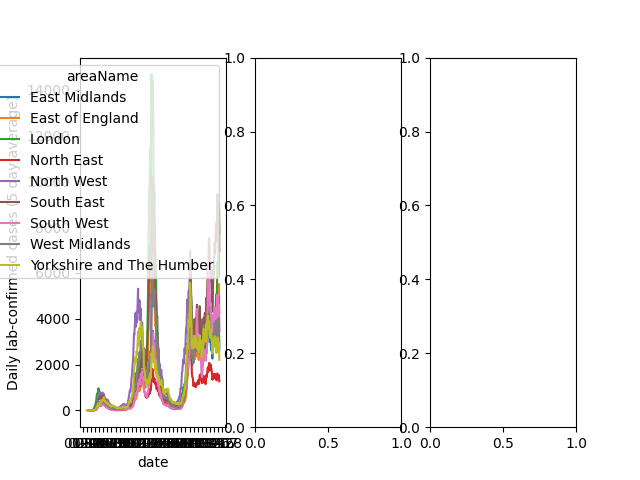

In [12]:
%matplotlib widget
f, axes = plt.subplots(1, 3)
p = sns.lineplot(y=f"Daily lab-confirmed cases ({n_days} day average)",
             x="date", 
             hue="areaName", 
             data=region_data, 
#              sort=False,
                 ax=axes[0])
# Define the date format
date_form = DateFormatter("%m-%d")
axes[0].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))

plt.show()
p2 = sns.lineplot(y=f"New deaths ({n_days} day average)",
                  x="date", 
                  hue="areaName", 
                  data=region_deaths, 
#                   sort=False,
                  ax=axes[1])

# Define the date format
date_form = DateFormatter("%m-%d")
axes[1].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))

p = sns.lineplot(y="Cumulative lab-confirmed cases per 100k population",
             x="date", 
             hue="areaName", 
             data=region_rates, 
                 ax=axes[2])
# Define the date format
date_form = DateFormatter("%m-%d")
axes[2].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
axes[2].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))


### Deaths by date and region

Deaths are recorded within 28 days.

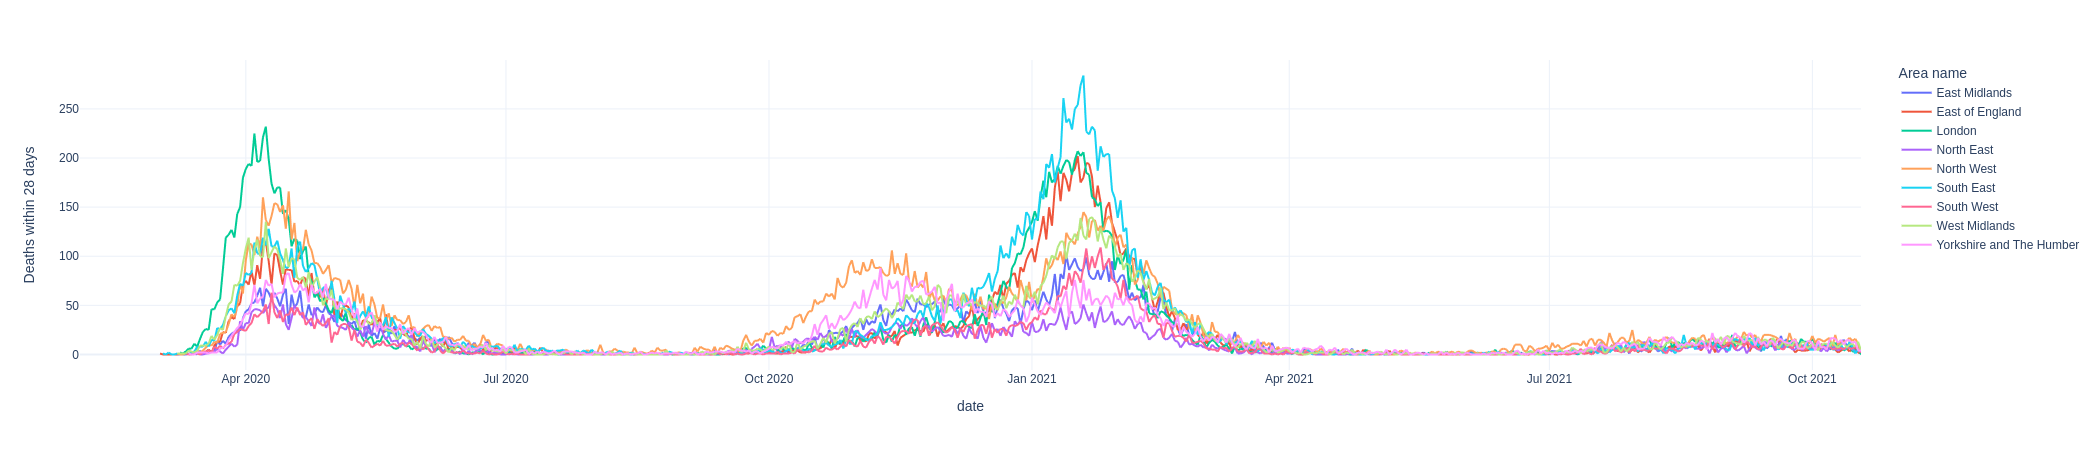

In [11]:
p = pex.line(x="date",
             y="Deaths within 28 days", 
             color="Area name", data_frame=region_data.rename(columns={"newDeaths28DaysByDeathDate" : "Deaths within 28 days", "areaName" : "Area name"}),
            template="plotly_white")
p

In [12]:
region_deaths

areaName       date  New deaths (5 day average)  \
15               East Midlands 2020-03-07                         0.2   
16               East Midlands 2020-03-08                         0.0   
17               East Midlands 2020-03-09                         0.0   
18               East Midlands 2020-03-10                         0.0   
19               East Midlands 2020-03-11                         0.0   
...                        ...        ...                         ...   
5464  Yorkshire and The Humber 2021-10-14                        13.2   
5465  Yorkshire and The Humber 2021-10-15                        13.2   
5466  Yorkshire and The Humber 2021-10-16                        12.8   
5467  Yorkshire and The Humber 2021-10-17                        11.6   
5468  Yorkshire and The Humber 2021-10-18                         9.4   

       areaCode  newCasesBySpecimenDate  cumCasesBySpecimenDate  \
15    E12000004                     5.0                    31.0   
16    E12000004                     1.0                    32.0   
17    E12000004                    10.0                    42.0   
18    E12000004                    12.0                    54.0   
19    E12000004                    25.0                    79.0   
...         ...                     ...                     ...   
5464  E12000003                  3920.0                780975.0   
5465  E12000003                  3399.0                784374.0   
5466  E12000003                  2948.0                787322.0   
5467  E12000003                  3078.0                790400.0   
5468  E12000003                   924.0                791324.0   

      cumCasesBySpecimenDateRate  newDeaths28DaysByDeathDate  \
15                           0.6                         0.0   
16                           0.7                         0.0   
17                           0.9                         0.0   
18                           1.1                         0.0   
19                           1.6                         0.0   
...                          ...                         ...   
5464                     14131.8                        14.0   
5465                     14193.3                        12.0   
5466                     14246.7                        13.0   
5467                     14302.4                         4.0   
5468                     14319.1                         4.0   

      cumDeaths28DaysByDeathDate  
15                           1.0  
16                           1.0  
17                           1.0  
18                           1.0  
19                           1.0  
...                          ...  
5464                     12167.0  
5465                     12179.0  
5466                     12192.0  
5467                     12196.0  
5468                     12200.0  

[5272 rows x 9 columns]

# Cumulative vs new cases

We plot on a log-log scale so that the drop off is more apparent

In [13]:
%matplotlib widget
p = sns.lineplot(y=f"Daily lab-confirmed cases ({n_days} day average)",
             x="Cumulative lab-confirmed cases", 
             hue="Area name", 
             data=region_data.rename(columns={"cumCasesBySpecimenDate" : "Cumulative lab-confirmed cases", "areaName" : "Area name"}), 
             sort=False)
p.set_yscale("log")
p.set_xscale("log")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Interactive version of the same graph using plotly

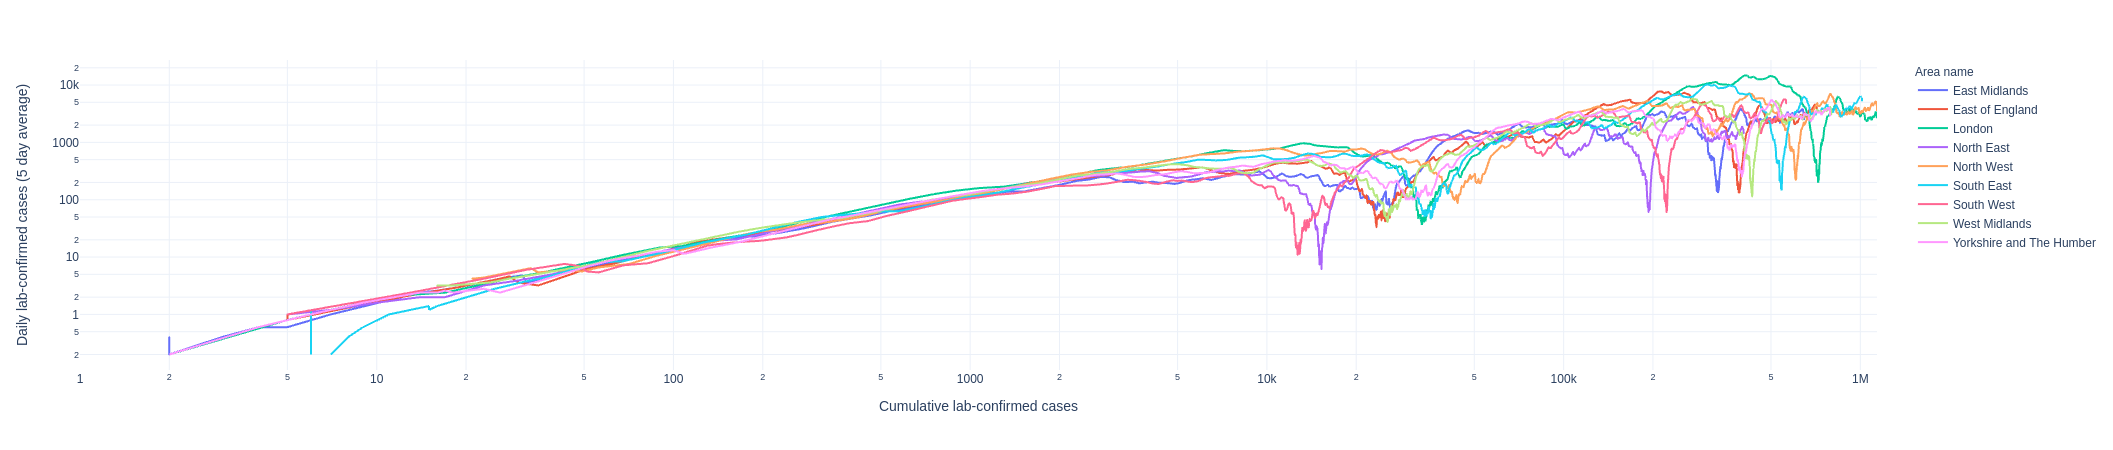

In [14]:
p = pex.line(y=f"Daily lab-confirmed cases ({n_days} day average)",
             x="Cumulative lab-confirmed cases", 
             color="Area name", data_frame=region_data.rename(columns={"cumCasesBySpecimenDate" : "Cumulative lab-confirmed cases", "areaName" : "Area name"}),
            template="plotly_white", log_x=True, log_y=True)
p

# Cumulative vs new deaths

In [15]:
%matplotlib widget
p = sns.lineplot(y=f"New deaths ({n_days} day average)",
             x="Cumulative deaths", 
             hue="Area name", 
             data=region_deaths.rename(columns={"cumDeaths28DaysByDeathDate" : "Cumulative deaths", "areaName" : "Area name"}), 
             sort=False)
p.set_yscale("log")
p.set_xscale("log")


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

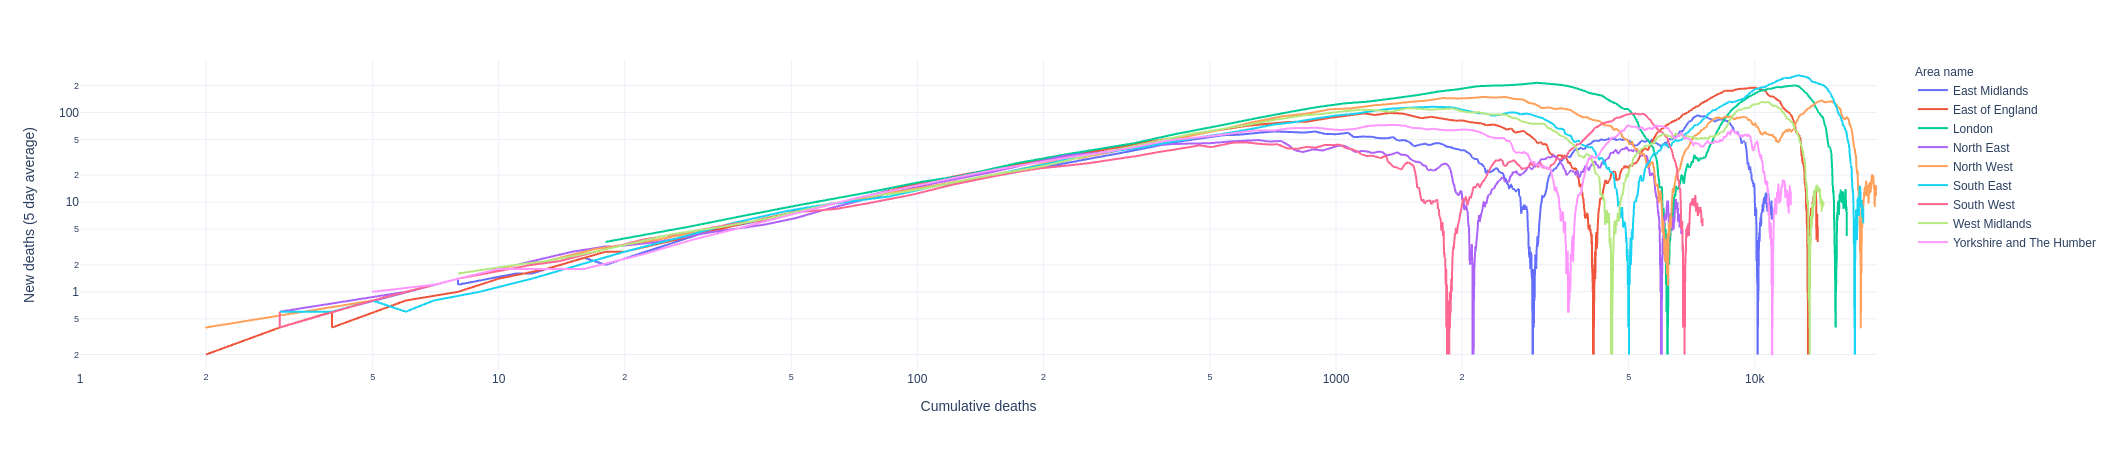

In [16]:
fig = pex.line(y=f"New deaths ({n_days} day average)",
             x="Cumulative deaths", 
             color="Area name", 
             data_frame=region_deaths.rename(columns={"cumDeaths28DaysByDeathDate" : "Cumulative deaths", "areaName" : "Area name"}),
             template="plotly_white")
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig

### Plot the country-level data

In [17]:
summary_data = region_data.groupby("date")[["Daily lab-confirmed cases (5 day average)", "newCasesBySpecimenDate", "cumCasesBySpecimenDate", "newDeaths28DaysByDeathDate", "cumDeaths28DaysByDeathDate"]].sum().reset_index()
summary_data = summary_data.melt(id_vars=["date", "cumCasesBySpecimenDate"], value_vars=["Daily lab-confirmed cases (5 day average)", "newCasesBySpecimenDate"])
summary_data["variable"] = summary_data["variable"].apply(lambda x: "5 day average" if x == "Daily lab-confirmed cases (5 day average)" else "daily")

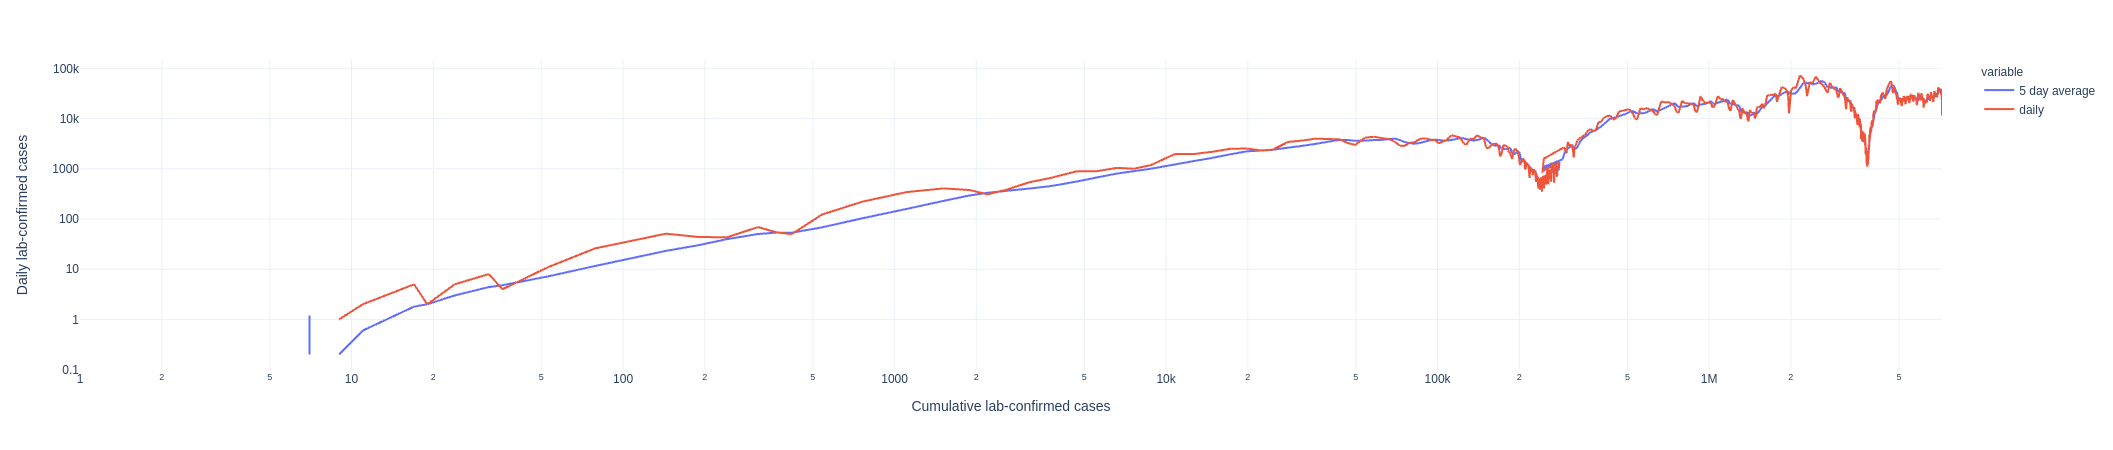

In [18]:
p = pex.line(y=f"Daily lab-confirmed cases",
             x="Cumulative lab-confirmed cases", 
             color="variable",
             data_frame=summary_data.rename(columns={"cumCasesBySpecimenDate" : "Cumulative lab-confirmed cases", "value" : "Daily lab-confirmed cases"}),
            template="plotly_white", log_x=True, log_y=True)
p

In [19]:
summary_deaths = region_deaths.groupby("date")[["New deaths (5 day average)", "newCasesBySpecimenDate", "cumCasesBySpecimenDate", "newDeaths28DaysByDeathDate", "cumDeaths28DaysByDeathDate"]].sum().reset_index()
summary_deaths = summary_deaths.melt(id_vars=["date", "cumDeaths28DaysByDeathDate"], value_vars=["New deaths (5 day average)", "newDeaths28DaysByDeathDate"])
summary_deaths["variable"] = summary_deaths["variable"].apply(lambda x: "5 day average" if x == "New deaths (5 day average)" else "daily")

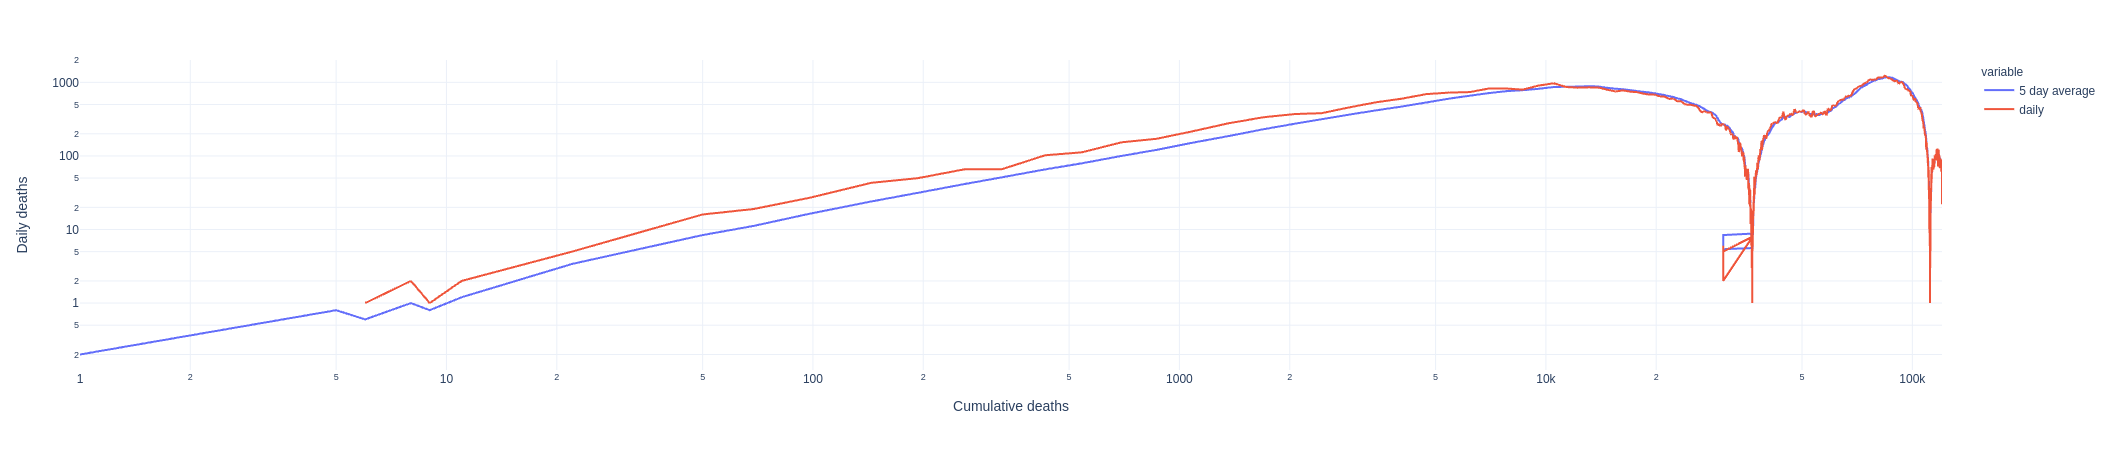

In [20]:
p = pex.line(y=f"Daily deaths",
             x="Cumulative deaths", 
             color="variable",
             data_frame=summary_deaths.rename(columns={"cumDeaths28DaysByDeathDate" : "Cumulative deaths", "value" : "Daily deaths"}),
            template="plotly_white", log_x=True, log_y=True)
p

### Plot case/death numbers as a proportion of the previous week's values

Use the rolling averages

In [21]:
rolling_week_data = region_data.sort_values(by=["areaName", "date"])

In [22]:
region_data

areaName       date  \
4                East Midlands 2020-02-25   
5                East Midlands 2020-02-26   
6                East Midlands 2020-02-27   
7                East Midlands 2020-02-28   
8                East Midlands 2020-02-29   
...                        ...        ...   
5464  Yorkshire and The Humber 2021-10-14   
5465  Yorkshire and The Humber 2021-10-15   
5466  Yorkshire and The Humber 2021-10-16   
5467  Yorkshire and The Humber 2021-10-17   
5468  Yorkshire and The Humber 2021-10-18   

      Daily lab-confirmed cases (5 day average)   areaCode  \
4                                           0.4  E12000004   
5                                           0.2  E12000004   
6                                           0.2  E12000004   
7                                           0.4  E12000004   
8                                           0.6  E12000004   
...                                         ...        ...   
5464                                     4127.8  E12000003   
5465                                     4106.0  E12000003   
5466                                     3730.4  E12000003   
5467                                     3498.2  E12000003   
5468                                     2853.8  E12000003   

      newCasesBySpecimenDate  cumCasesBySpecimenDate  \
4                        1.0                     2.0   
5                        0.0                     2.0   
6                        0.0                     2.0   
7                        1.0                     3.0   
8                        1.0                     4.0   
...                      ...                     ...   
5464                  3920.0                780975.0   
5465                  3399.0                784374.0   
5466                  2948.0                787322.0   
5467                  3078.0                790400.0   
5468                   924.0                791324.0   

      cumCasesBySpecimenDateRate  newDeaths28DaysByDeathDate  \
4                            NaN                         NaN   
5                            NaN                         NaN   
6                            NaN                         NaN   
7                            0.1                         NaN   
8                            0.1                         NaN   
...                          ...                         ...   
5464                     14131.8                        14.0   
5465                     14193.3                        12.0   
5466                     14246.7                        13.0   
5467                     14302.4                         4.0   
5468                     14319.1                         4.0   

      cumDeaths28DaysByDeathDate  
4                            NaN  
5                            NaN  
6                            NaN  
7                            NaN  
8                            NaN  
...                          ...  
5464                     12167.0  
5465                     12179.0  
5466                     12192.0  
5467                     12196.0  
5468                     12200.0  

[5427 rows x 9 columns]

In [23]:
import numpy as np
rolling_week_data["average_ratio_cases"] = np.NaN
# rolling_week_data["average_ratio_cases"] =
rolling_week_data["average_ratio_cases"].iloc[5:] = rolling_week_data["Daily lab-confirmed cases (5 day average)"].iloc[5:].values / rolling_week_data["Daily lab-confirmed cases (5 day average)"].iloc[:-5].values

<ipython-input-23-f1e89c9e287b>:4: RuntimeWarning:

divide by zero encountered in true_divide

<ipython-input-23-f1e89c9e287b>:4: RuntimeWarning:

invalid value encountered in true_divide

/home/samt/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



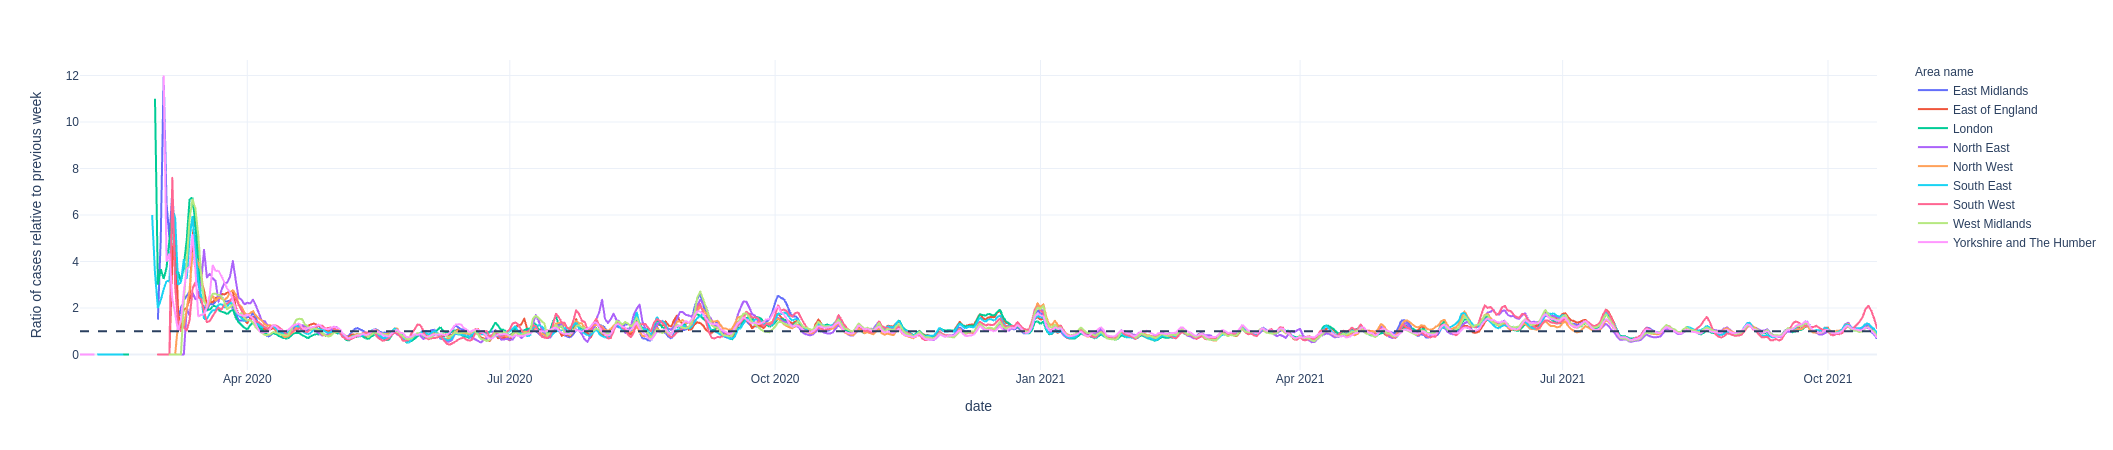

In [24]:
y_axis = "Ratio of cases relative to previous week"
fig = pex.line(y=y_axis,
             x="date", 
             color="Area name", 
             data_frame=rolling_week_data.rename(columns={"average_ratio_cases" : y_axis, "areaName" : "Area name"}),
             template="plotly_white")
fig.add_hline(y=1.0, line_dash="dash")
# fig.update_layout(xaxis_type="log", yaxis_type="log")
fig

#### Group by all regions

In [25]:
daily_col = "Daily lab-confirmed cases (5 day average)"
rolling_week_data_regions = region_data.groupby(["date"])[daily_col].sum().reset_index()

In [26]:
rolling_week_data_regions["average_ratio_cases"] = 0
rolling_week_data_regions["average_ratio_cases"].iloc[5:] = rolling_week_data_regions[daily_col].iloc[5:].values / rolling_week_data_regions[daily_col].iloc[:-5].values

<ipython-input-26-07f7d80eebaa>:2: RuntimeWarning:

divide by zero encountered in true_divide

<ipython-input-26-07f7d80eebaa>:2: RuntimeWarning:

invalid value encountered in true_divide



In [27]:
rolling_week_data_regions

date  Daily lab-confirmed cases (5 day average)  average_ratio_cases
0   2020-02-03                                        0.2             0.000000
1   2020-02-04                                        0.0             0.000000
2   2020-02-05                                        0.0             0.000000
3   2020-02-06                                        0.0             0.000000
4   2020-02-07                                        0.0             0.000000
..         ...                                        ...                  ...
619 2021-10-14                                    38003.4             1.266603
620 2021-10-15                                    38918.6             1.302706
621 2021-10-16                                    36405.2             1.139964
622 2021-10-17                                    35207.8             1.047427
623 2021-10-18                                    29624.8             0.830222

[624 rows x 3 columns]

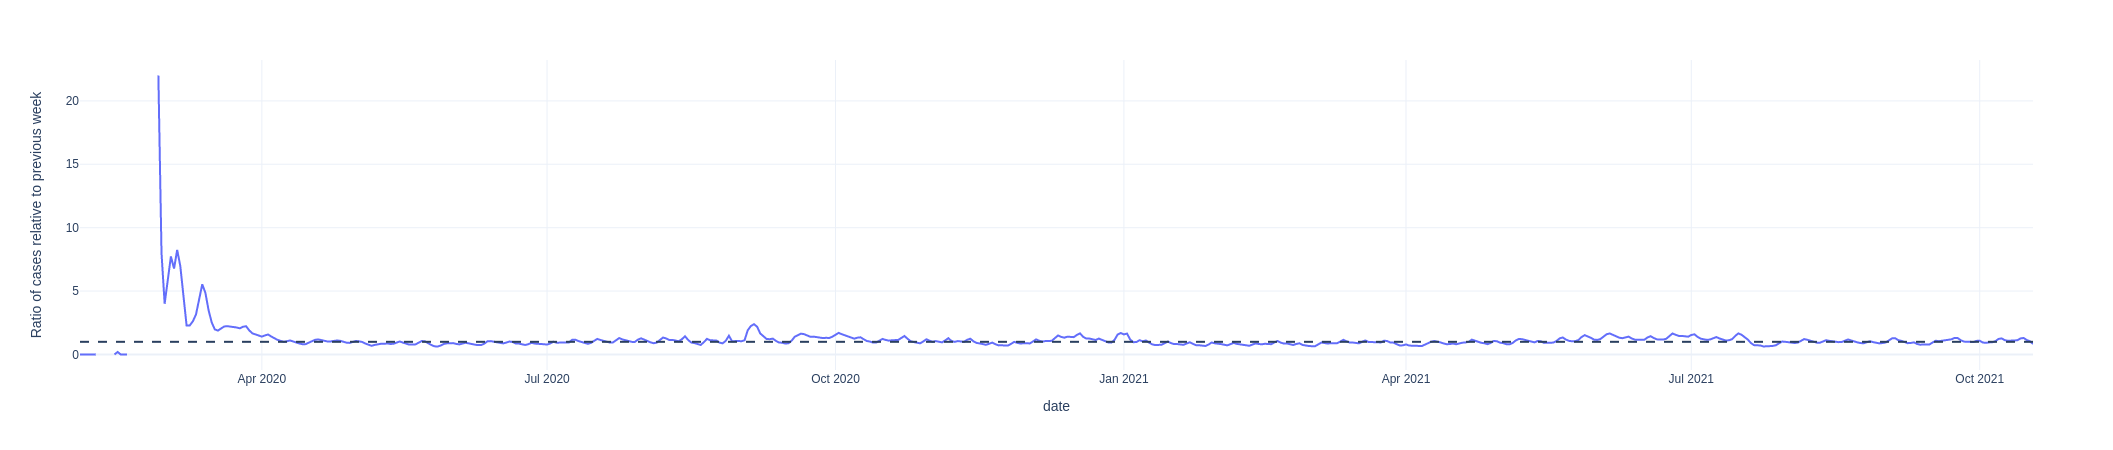

In [28]:
fig = pex.line(y=y_axis,
             x="date", 
             data_frame=rolling_week_data_regions.rename(columns={"average_ratio_cases" : y_axis, "areaName" : "Area name"}),
             template="plotly_white")
fig.add_hline(y=1.0, line_dash="dash")
# fig.update_layout(xaxis_type="log", yaxis_type="log")
fig

In [29]:
rolling_week_data["Daily lab-confirmed cases (5 day average)"].iloc[0:-1]

4          0.4
5          0.2
6          0.2
7          0.4
8          0.6
         ...  
5463    3967.4
5464    4127.8
5465    4106.0
5466    3730.4
5467    3498.2
Name: Daily lab-confirmed cases (5 day average), Length: 5426, dtype: float64

In [30]:
rolling_week_data["Daily lab-confirmed cases (5 day average)"].iloc[1:].values

array([2.0000e-01, 2.0000e-01, 4.0000e-01, ..., 3.7304e+03, 3.4982e+03,
       2.8538e+03])